In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls
%cd /content/drive/MyDrive/9517/

Confusion_matrix_lgb.png  rotation		       test_hog.npy
confusion_matrix_svm.png  rotation_double	       train_hog_inbalance8.npy
elpv-dataset		  svm_model_best.joblib        train_hog_inbalance_best.npy
lgb_model.txt		  svm_model.joblib	       train_hog_inbalance_lgb.npy
P-R_curve_lgb.png	  test_hog_inbalance8.npy      train_hog_inbalance.npy
P-R_curve_svm.png	  test_hog_inbalance_best.npy  train_hog.npy
ROC_curve_lgb.png	  test_hog_inbalance_lgb.npy   Train_valid_lgb.png
ROC_curve_svm.png	  test_hog_inbalance.npy
/content/drive/MyDrive/9517


In [ ]:
import PIL
import cv2
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import copy
import os

from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split,GridSearchCV
from skimage import io
from skimage.feature import hog
from PIL import Image
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import xgboost as xgb

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
#load data
sys.path.append('/content/drive/MyDrive/9517/elpv-dataset/utils')
from elpv_reader import load_dataset
images, proba, types = load_dataset()
size=300

Show the distribution for mono and poly

In [ ]:
# divide the data
mono_img=[]
poly_img=[]
mono_prob=[]
poly_prob=[]
for i in range(len(types)):
  if types[i]=='mono':
    mono_img.append(images[i])
    mono_prob.append(proba[i])
  else:
    poly_img.append(images[i])
    poly_prob.append(proba[i])

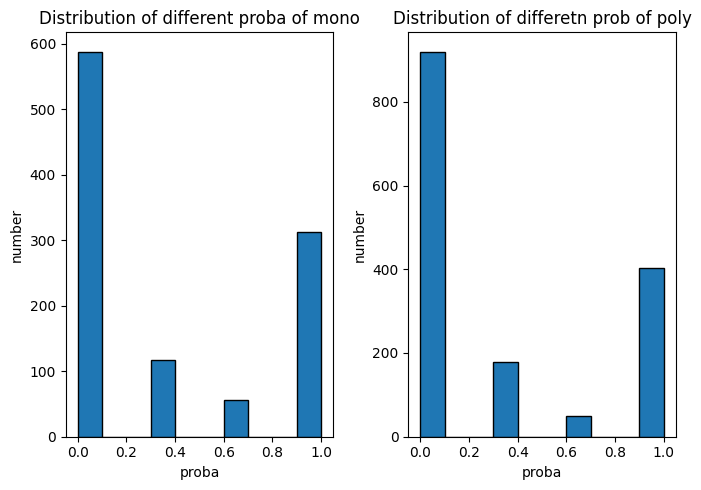

In [ ]:
#data visualisation
fig,ax=plt.subplots(1,2,figsize=(7,5))
hist1=ax[0].hist(mono_prob,bins=[0,0.1, 0.3,0.4,0.6,0.7,0.9,1],edgecolor='black')
ax[0].set_title('Distribution of different proba of mono')
ax[0].set_xlabel('proba')
ax[0].set_ylabel('number')

hist2=ax[1].hist(poly_prob,bins=[0,0.1, 0.3,0.4,0.6,0.7,0.9,1],edgecolor='black')
ax[1].set_title('Distribution of differetn prob of poly')
ax[1].set_xlabel('proba')
ax[1].set_ylabel('number')

plt.tight_layout()
plt.show()

Data Augmentation, run this code to generate image to corresponding folder

In [ ]:
#data augumentataion to create balanced data
#extract differnt class image
mono_2=[]
mono_3=[]
poly_2=[]
poly_3=[]

for i in range(len(mono_prob)):
  if mono_prob[i]>0 and mono_prob[i]<0.6:
    mono_2.append(cv2.cvtColor(mono_img[i], cv2.COLOR_GRAY2RGB))
  elif mono_prob[i]>0.6 and mono_prob[i]<1:
    mono_3.append(cv2.cvtColor(mono_img[i], cv2.COLOR_GRAY2RGB))


for j in range (len(poly_prob)):
  if poly_prob[j]>0 and poly_prob[j]<0.6:
    poly_2.append(cv2.cvtColor(poly_img[j], cv2.COLOR_GRAY2RGB))
  elif poly_prob[j]>0.6 and poly_prob[j]<1:
    poly_3.append(cv2.cvtColor(poly_img[j], cv2.COLOR_GRAY2RGB))



mono_2=np.array(mono_2)
mono_3=np.array(mono_3)
poly_2=np.array(poly_2)
poly_3=np.array(poly_3)


#create regenrator
img_generator=ImageDataGenerator(rotation_range=90,
                                  horizontal_flip=True,
                                  fill_mode='reflect')
mono2_count=0
mono3_count=0
poly2_count=0
poly3_count=0


for batch in img_generator.flow(mono_2,batch_size=4,save_to_dir='rotation/mono2',save_prefix='mono',save_format='png'):
  mono2_count+=1
  if mono2_count>45:
    break

for batch in img_generator.flow(mono_3,batch_size=4,save_to_dir='rotation/mono3',save_prefix='mono',save_format='png'):
  mono3_count+=1
  if mono3_count>61:
    break

for batch in img_generator.flow(poly_2,batch_size=4,save_to_dir='rotation/poly2',save_prefix='poly',save_format='png'):
  poly2_count+=1
  if poly2_count>50:
    break

for batch in img_generator.flow(poly_3,batch_size=4,save_to_dir='rotation/poly3',save_prefix='poly',save_format='png'):
  poly3_count+=1
  if poly3_count>73:
    break


Import created data and origianl data

In [ ]:
#import picture and transform to array
mono2_gray=[]
mono3_gray=[]
mono4_gray=[]
poly2_gray=[]
poly3_gray=[]
poly4_gray=[]

img_mono2=os.listdir('rotation/mono2/')
img_mono3=os.listdir('rotation/mono3/')
img_poly2=os.listdir('rotation/poly2/')
img_poly3=os.listdir('rotation/poly3/')


for i, image_name in enumerate(img_mono2):
    if (image_name.split('.')[1] == 'png'):
        image = io.imread('rotation/mono2/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        image = np.array(image)
        mono2_gray.append(np.array(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)))
mono2_gray=np.array(mono2_gray)

for i, image_name in enumerate(img_mono3):
    if (image_name.split('.')[1] == 'png'):
        image = io.imread('rotation/mono3/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        image = np.array(image)
        mono3_gray.append(np.array(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)))
mono3_gray=np.array(mono3_gray)

for i, image_name in enumerate(img_poly2):
    if (image_name.split('.')[1] == 'png'):
        image = io.imread('rotation/poly2/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        image = np.array(image)
        poly2_gray.append(np.array(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)))
poly2_gray=np.array(poly2_gray)

for i, image_name in enumerate(img_poly3):
    if (image_name.split('.')[1] == 'png'):
        image = io.imread('rotation/poly3/'+image_name)
        image = Image.fromarray(image, 'RGB')
        image = image.resize((size,size))
        image = np.array(image)
        poly3_gray.append(np.array(cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)))
poly3_gray=np.array(poly3_gray)


In [ ]:
#import original image
image_gray_hog=[]
for i in range(len(images)):
  image_gray_hog.append(np.array(images[i]))
image_gray_hog=np.array(image_gray_hog)

#transform prob into category
distinct=list(set(proba))

category=[]
for i in proba:
  if i==distinct[0]:
    category.append(0)
  elif i==distinct[1]:
    category.append(3)
  elif i==distinct[2]:
    category.append(2)
  else:
    category.append(1)
#merge orignal data and rotated data
image_gray_hog=np.vstack((image_gray_hog,mono2_gray))
image_gray_hog=np.vstack((image_gray_hog,mono3_gray))
image_gray_hog=np.vstack((image_gray_hog,poly2_gray))
image_gray_hog=np.vstack((image_gray_hog,poly3_gray))
category=category+[1]*(mono2_gray.shape[0])+[2]*(mono3_gray.shape[0])+[1]*(poly2_gray.shape[0])+[2]*(poly3_gray.shape[0])
for i in range(mono2_gray.shape[0]):
  types=np.append(types,'mono')
for i in range(mono3_gray.shape[0]):
  types=np.append(types,'mono')
for i in range(poly2_gray.shape[0]):
  types=np.append(types,'poly')
for i in range(poly3_gray.shape[0]):
  types=np.append(types,'poly')

print(types.shape)
#Histogram equalization and noise filter
for i in range (image_gray_hog.shape[0]):
  image_gray_hog[i,:,:] = cv2.GaussianBlur(image_gray_hog[i,:,:], (5, 5), 0)
  image_gray_hog[i,:,:,]=cv2.equalizeHist(image_gray_hog[i,:,:])

#divide the train and test
type_train,type_test,_,_=train_test_split(types,category,test_size=0.25,stratify=category,random_state=42)
img_train_hog,img_test_hog,prob_train,prob_test=train_test_split(image_gray_hog,category,test_size=0.25,stratify=category,random_state=42)
print(img_train_hog.shape)
print(img_test_hog.shape)
print(type_test.shape)

(3545,)
(2658, 300, 300)
(887, 300, 300)
(887,)


Plot the distribution after data augmentation


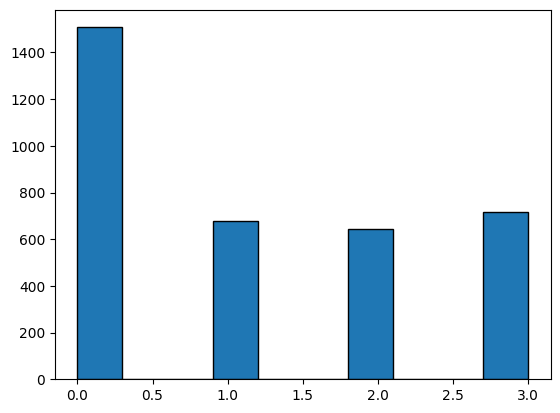

In [ ]:
#plot the hist after augmentation
plt.hist(category,edgecolor='black')
plt.show()

Run HOG to extract parameter

<ipython-input-11-33415c422004>:7: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd,hog_image=hog(img_train_hog[i],orientations=8,pixels_per_cell=(8,8),


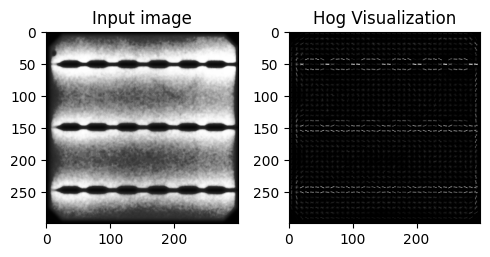

<ipython-input-11-33415c422004>:22: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  fd,hog_image=hog(img_test_hog[i],orientations=8,pixels_per_cell=(8,8),


In [ ]:
#use hog to extract parameter
train_hog=[]
test_hog=[]


for i in range (img_train_hog.shape[0]):
  fd,hog_image=hog(img_train_hog[i],orientations=8,pixels_per_cell=(8,8),
                   cells_per_block=(2,2),visualize=True,multichannel=False)
  train_hog.append(fd)
  if i==0:
    fig,axe=plt.subplots(1,2,figsize=(5,5))
    axe[0].imshow(img_train_hog[0],cmap='gray')
    axe[0].set_title('Input image')

    axe[1].imshow(hog_image,cmap='gray')
    axe[1].set_title('Hog Visualization')

    plt.tight_layout()
    plt.show()

for i in range (img_test_hog.shape[0]):
  fd,hog_image=hog(img_test_hog[i],orientations=8,pixels_per_cell=(8,8),
                   cells_per_block=(2,2),visualize=True,multichannel=False)
  test_hog.append(fd)

Train SVM model and get confusion matrix

The result report of hog+svm is :
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       377
           1       0.57      0.33      0.42       170
           2       0.62      0.65      0.63       161
           3       0.80      0.69      0.74       179

    accuracy                           0.71       887
   macro avg       0.69      0.65      0.66       887
weighted avg       0.70      0.71      0.70       887

the confusion matrix of hog+svm is:
 [[351   4   0  22]
 [ 45  56  63   6]
 [ 20  34 104   3]
 [ 51   4   1 123]]


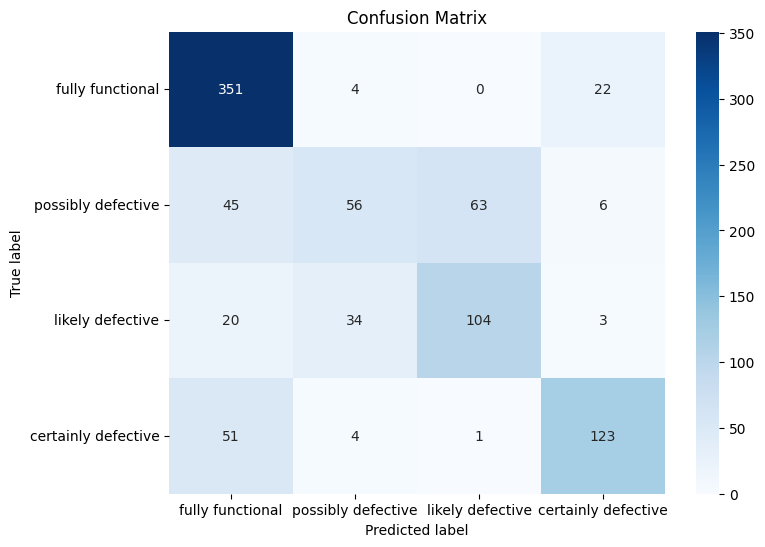

In [ ]:
#create svm for multiclassification
#standardlize parameters extracted

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import seaborn as sns
import joblib

scaler = StandardScaler()
train_hog = scaler.fit_transform(train_hog)
test_hog = scaler.fit_transform(test_hog)

#fit the model and conduct prediction
svm_model=OneVsRestClassifier(SVC(C=100,kernel='rbf'))


svm_model.fit(train_hog,prob_train)

#store the model
# model_filename = 'svm_model_best.joblib'
# joblib.dump(svm_model, model_filename)

prediction_svm=svm_model.predict(test_hog)
matrix=metrics.confusion_matrix(prob_test,prediction_svm)
print(f"The result report of hog+svm is :\n {metrics.classification_report(prob_test,prediction_svm)}")
print(f"the confusion matrix of hog+svm is:\n {matrix}")
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues', xticklabels=['fully functional', 'possibly defective','likely defective','certainly defective'], yticklabels=['fully functional', 'possibly defective','likely defective','certainly defective'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

Generate ROC and P-R curve

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 # calculate the score of the model
y_score=svm_model.decision_function(test_hog)

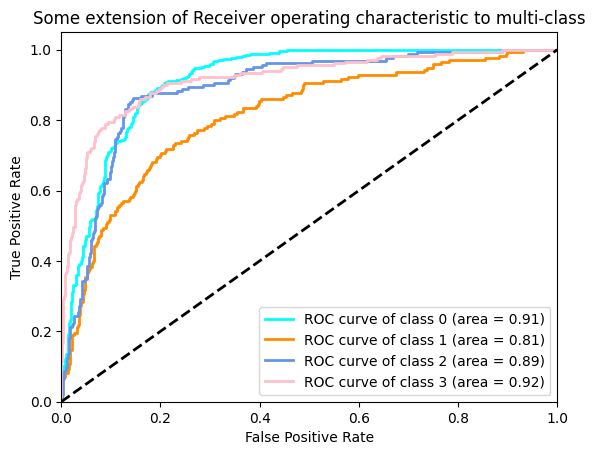

In [ ]:
from sklearn.preprocessing import label_binarize
from itertools import cycle

y=label_binarize(prob_test, classes=[0, 1, 2,3])

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# draw Roc line
lw=2
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','pink'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
# plt.savefig('ROC_curve_svm_best.png')
plt.show()

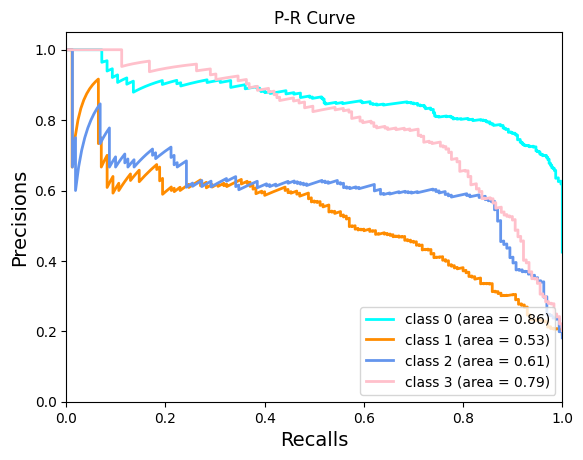

In [ ]:
from sklearn.metrics import precision_recall_curve,average_precision_score
precision=[]
recall=[]
average=[]
for i in range(4):
  precisions, recalls, thresholds = precision_recall_curve(y[:,i], y_score[:,i])
  average_precision = average_precision_score(y[:,i], y_score[:,i])
  precision.append(precisions)
  recall.append(recalls)
  average.append(average_precision)

lw=2
plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue','pink'])
for i, color in zip(range(4), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='class {0} (area = {1:0.2f})'''.format(i,average[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('P-R Curve')
plt.xlabel('Recalls', fontsize=14)
plt.ylabel('Precisions', fontsize=14)
plt.legend(loc="lower right")
# plt.savefig('P-R_curve_svm_best.png')
plt.show()


Make prediction on mono and poly respectively

In [ ]:
mono_test=[]
mono_prob=[]
poly_test=[]
poly_prob=[]
for i in range (type_test.shape[0]):
  if type_test[i]=='mono':
    mono_test.append(test_hog[i,:,])
    mono_prob.append(prob_test[i])
  else:
    poly_test.append(test_hog[i,:,])
    poly_prob.append(prob_test[i])

In [ ]:
mono_prediction=svm_model.predict(mono_test)
print(f"The result report of mono is :\n {metrics.classification_report(mono_prob,mono_prediction)}")
poly_prediction=svm_model.predict(poly_test)
print(f"The result report of poly is :\n {metrics.classification_report(poly_prob,poly_prediction)}")

The result report of mono is :
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       149
           1       0.53      0.41      0.46        70
           2       0.56      0.49      0.52        75
           3       0.86      0.72      0.78        83

    accuracy                           0.70       377
   macro avg       0.67      0.64      0.65       377
weighted avg       0.69      0.70      0.69       377

The result report of poly is :
               precision    recall  f1-score   support

           0       0.75      0.93      0.83       228
           1       0.63      0.27      0.38       100
           2       0.66      0.78      0.71        86
           3       0.75      0.66      0.70        96

    accuracy                           0.72       510
   macro avg       0.70      0.66      0.66       510
weighted avg       0.71      0.72      0.70       510

